# Graph Initialization

In [1]:
import pandas as pd
import math
import random

from collections import defaultdict, deque
from typing import Dict, Set, Tuple, List

In [2]:
def initialize_multiplex_hypergraph(w: int, h: int):
    nodes = {1: set(), 2: set(), 3: set()}
    for i in range(w):
        for j in range(h):
            nodes[1].add((i, j))
            if (i + j) % 2 == 1:
                nodes[2].add((i, j))
            if (i + j) % 2 == 0:
                nodes[3].add((i, j))

    hyperedges = {1: [], 2: [], 3: []}
    for i, j in nodes[1]:
        if (i + 1, j) in nodes[1]:
            hyperedges[1].append(((i, j), (i + 1, j)))
        if (i, j + 1) in nodes[1]:
            hyperedges[1].append(((i, j), (i, j + 1)))

    for i, j in nodes[2]:
        candidates = [(i + 1, j + 1), (i + 2, j)]
        if all(pt in nodes[2] for pt in candidates):
            hyperedges[2].append(((i, j), (i + 1, j + 1), (i + 2, j)))

    for i, j in nodes[3]:
        if i % 2 == 0 and j % 2 == 0:
            candidates = [(i + 1, j - 1), (i + 1, j + 1), (i + 2, j)]
            if all(pt in nodes[3] for pt in candidates):
                hyperedges[3].append(((i, j), (i + 1, j - 1), (i + 1, j + 1), (i + 2, j)))

    return nodes, hyperedges

In [3]:
# Example usage
nodes, hyperedges = initialize_multiplex_hypergraph(6, 6)

# Summary print
summary = pd.DataFrame({
    "Layer": ["1 (degree-2)", "2 (degree-3)", "3 (degree-4)"],
    "Activated Hyperedges": [len(hyperedges[1]), len(hyperedges[2]), len(hyperedges[3])]
})
print(summary)

          Layer  Activated Hyperedges
0  1 (degree-2)                    60
1  2 (degree-3)                    10
2  3 (degree-4)                     4


# Percolation Process 

In [4]:
# Define percolation function
def apply_percolation(
    hyperedges: Dict[int, List[Tuple[Tuple[int, int], ...]]],
    sigma: float
) -> Dict[int, List[Tuple[Tuple[int, int], ...]]]:
    survived = {}
    for layer, hedges in hyperedges.items():
        m = len(hedges[0]) if hedges else layer  # infer degree from sample
        p_m = math.exp(-m / sigma)
        survived[layer] = [h for h in hedges if random.random() < p_m]
    return survived

# Measure of Connectivity

In [5]:
def compute_EGR(
    nodes: Dict[int, Set[Tuple[int, int]]],
    hyperedges: Dict[int, List[Tuple[Tuple[int, int], ...]]],
    source: Tuple[int, int],
    target: Tuple[int, int]
) -> int:
    all_hyperedges = []
    for layer in hyperedges:
        all_hyperedges.extend(hyperedges[layer])

    node_to_hyperedges = defaultdict(set)
    for idx, hedge in enumerate(all_hyperedges):
        for node in hedge:
            node_to_hyperedges[node].add(idx)

    used_hyperedges = set()
    EGR = 0

    def dfs(current, target, visited_nodes, used_hyperedges_local):
        if current == target:
            return []
        for hedge_idx in node_to_hyperedges[current]:
            if hedge_idx in used_hyperedges_local:
                continue
            hedge = all_hyperedges[hedge_idx]
            for next_node in hedge:
                if next_node == current or next_node in visited_nodes:
                    continue
                path = dfs(next_node, target, visited_nodes | {next_node}, used_hyperedges_local | {hedge_idx})
                if path is not None:
                    return [hedge_idx] + path
        return None

    while True:
        path = dfs(source, target, {source}, used_hyperedges)
        if path is None:
            break
        used_hyperedges.update(path)
        EGR += 1

    return EGR

def compute_R(
    nodes: Dict[int, Set[Tuple[int, int]]],
    hyperedges: Dict[int, List[Tuple[Tuple[int, int], ...]]]
) -> float:
    all_hyperedges = []
    for layer in hyperedges:
        all_hyperedges.extend(hyperedges[layer])

    adjacency = defaultdict(set)
    for hedge in all_hyperedges:
        for u in hedge:
            for v in hedge:
                if u != v:
                    adjacency[u].add(v)

    visited = set()
    max_component_size = 0

    for node in set().union(*nodes.values()):
        if node in visited:
            continue
        queue = deque([node])
        component = set()
        while queue:
            curr = queue.popleft()
            if curr in visited:
                continue
            visited.add(curr)
            component.add(curr)
            queue.extend(adjacency[curr] - visited)
        max_component_size = max(max_component_size, len(component))

    total_nodes = len(set().union(*nodes.values()))
    R = max_component_size / total_nodes if total_nodes > 0 else 0.0

    return R

# Run Trial

In [6]:
def run_percolation_trials(
    w: int,
    h: int,
    sigma: float,
    N: int = 100
) -> Tuple[float, float]:
    """
    Run N percolation trials and return the average EGR and R.
    
    Args:
        w, h: Grid size
        sigma: Percolation softness parameter
        N: Number of trials
    
    Returns:
        (avg_EGR, avg_R): Averages over trials
    """
    nodes, hyperedges = initialize_multiplex_hypergraph(w, h)
    EGR_list = []
    R_list = []

    for _ in range(N):
        percolated_hyperedges = apply_percolation(hyperedges, sigma)
        EGR = compute_EGR(nodes, percolated_hyperedges, (0, 0), (w - 1, h - 1))
        R = compute_R(nodes, percolated_hyperedges)
        EGR_list.append(EGR)
        R_list.append(R)

    avg_EGR = sum(EGR_list) / N
    avg_R = sum(R_list) / N
    return avg_EGR, avg_R

In [7]:
# Example: Run N trials for sigma
w, h = 6, 6
sigma_val = 2.0
N_trials = 100
avg_EGR, avg_R = run_percolation_trials(w, h, sigma_val, N_trials)

pd.DataFrame([{
    "Grid Size": f"{w}x{h}",
    "Sigma": sigma_val,
    "Trials": N_trials,
    "Average EGR": avg_EGR,
    "Average R": avg_R
}])

,Grid Size,Sigma,Trials,Average EGR,Average R
0,6x6,2.0,100,0.08,0.509722


# Plot

Sweeping over sigma values: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]


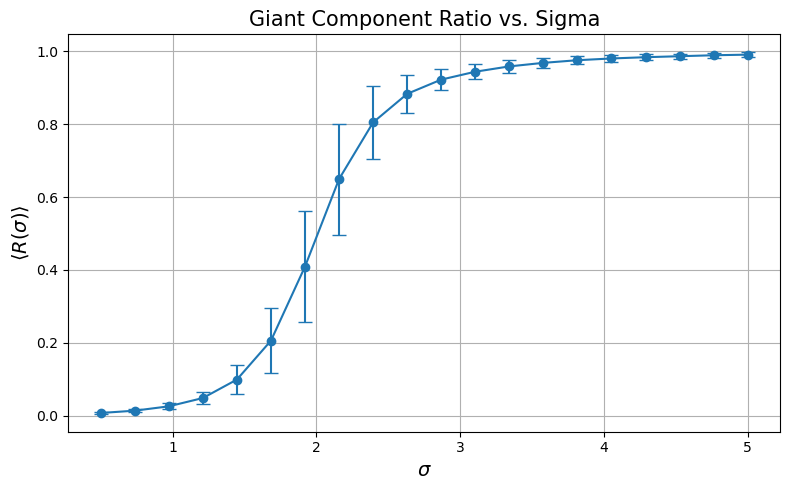

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

def sweep_R_vs_sigma_with_progress(
    w: int,
    h: int,
    sigma_values: List[float],
    N: int = 100
) -> pd.DataFrame:

    nodes, hyperedges = initialize_multiplex_hypergraph(w, h)
    results = []

    for sigma in tqdm(sigma_values, desc="Sweeping over sigma values"):
        R_list = []
        for _ in range(N):
            percolated_hyperedges = apply_percolation(hyperedges, sigma)
            R = compute_R(nodes, percolated_hyperedges)
            R_list.append(R)
        avg_R = np.mean(R_list)
        std_R = np.std(R_list)
        results.append({
            "Sigma": sigma,
            "Average_R": avg_R,
            "Std_R": std_R
        })

    return pd.DataFrame(results)

def plot_R_vs_sigma(df: pd.DataFrame):
    plt.figure(figsize=(8, 5))
    plt.errorbar(df["Sigma"], df["Average_R"], yerr=df["Std_R"], fmt='o-', capsize=5)
    plt.xlabel(r"$\sigma$", fontsize=14)
    plt.ylabel(r"$\langle R(\sigma) \rangle$", fontsize=14)
    plt.title("Giant Component Ratio vs. Sigma", fontsize=15)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
sigma_values = np.linspace(0.5, 5.0, 20)  # test

# Rerun the sweep with tqdm-enabled version
R_vs_sigma_df = sweep_R_vs_sigma_with_progress(w=20, h=20, sigma_values=sigma_values.tolist(), N=1000)
plot_R_vs_sigma(R_vs_sigma_df)